In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [20]:
words = open('../data/names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [21]:
nbr_neurons = 256
vocab_size = 27
emb_dim = 5
block_size = 3 # context window size

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size, emb_dim), generator=g)
W1 = torch.randn((emb_dim*block_size, nbr_neurons), generator=g)
b1 = torch.randn(nbr_neurons, generator=g)
W2 = torch.randn((nbr_neurons, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) 

11170

In [22]:
# build the dataset

def build_dataset(words, block_size=block_size):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  #print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [23]:
for p in parameters:
        p.requires_grad = True 
stepi, lossi, Ci = [], [], []

In [24]:
n = 50000
batch_size = 50


for i in range(n):
    # minibatch construct 
    ixs = torch.randint(0, Xtr.shape[0], (batch_size,)) 

    # Forward pass 
    emb = C[Xtr[ixs]] 
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ytr[ixs]) 

    # Backward pass
    for p in parameters:
        p.grad = None 

    loss.backward()

    # update
    #l = 0.1 if i < 300000 else 0.01
    l = 0.01
    for p in parameters:
        p.data += -l * p.grad 

    stepi.append(i)
    lossi.append(loss.item())
    C_clone = C.detach().clone()
    Ci.append(C_clone)

print(loss)

tensor(2.2524, grad_fn=<NllLossBackward0>)


In [25]:
def model_test(X,Y):
    emb = C[X] 
    h = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y) 
    return loss

ldev = model_test(Xdev, Ydev)
ltest = model_test(Xte, Yte)
print("dev : ", ldev)
print("test : ", ltest)

dev :  tensor(2.4256, grad_fn=<NllLossBackward0>)
test :  tensor(2.4339, grad_fn=<NllLossBackward0>)


In [26]:
import random

nbr_neurons_choices = [128, 256, 512]
emb_dim_choices = [3, 5, 7]       
block_size_choices = [3, 4, 5]      

n_trials = 10
n_iter = 1000000     

best_loss = float('inf')
best_config = None

for trial in range(n_trials):
    nbr_neurons_trial = random.choice(nbr_neurons_choices)
    emb_dim_trial = random.choice(emb_dim_choices)
    block_size_trial = random.choice(block_size_choices)

    Xtr, Ytr = build_dataset(words[:n1], block_size_trial)
    Xdev, Ydev = build_dataset(words[n1:n2], block_size_trial)
    Xte, Yte = build_dataset(words[n2:], block_size_trial)
    
    
    C_trial = torch.randn((vocab_size, emb_dim_trial), generator=g, requires_grad=True)
    W1_trial = torch.randn((block_size_trial * emb_dim_trial, nbr_neurons_trial), generator=g, requires_grad=True)
    b1_trial = torch.randn(nbr_neurons_trial, generator=g, requires_grad=True)
    W2_trial = torch.randn((nbr_neurons_trial, vocab_size), generator=g, requires_grad=True)
    b2_trial = torch.randn(vocab_size, generator=g, requires_grad=True)
    
    parameters_trial = [C_trial, W1_trial, b1_trial, W2_trial, b2_trial]
    
    
    for i in range(n_iter):
        lr = 0.1 if n_iter < 0.8*n_iter else 0.01
        
        ixs = torch.randint(0, Xtr.shape[0], (batch_size,))
        
        # Forward pass
        emb = C_trial[Xtr[ixs]]
        h = torch.tanh(emb.view(-1, block_size_trial * emb_dim_trial) @ W1_trial + b1_trial)
        logits = h @ W2_trial + b2_trial
        loss = F.cross_entropy(logits, Ytr[ixs])
        
        # Backward pass
        for p in parameters_trial:
            if p.grad is not None:
                p.grad.zero_()
        loss.backward()
        
        # Update
        with torch.no_grad():
            for p in parameters_trial:
                p.add_(-lr * p.grad)
    
    # eval 
    emb_dev = C_trial[Xdev]
    h_dev = torch.tanh(emb_dev.view(-1, block_size_trial * emb_dim_trial) @ W1_trial + b1_trial)
    logits_dev = h_dev @ W2_trial + b2_trial
    dev_loss = F.cross_entropy(logits_dev, Ydev)
    
    print(f"Trial {trial+1}: lr={lr}, "
          f"nbr_neurons={nbr_neurons_trial}, "
          f"emb_dim={emb_dim_trial}, block_size={block_size_trial}, "
          f"dev_loss={dev_loss.item()}")
    
    # Meilleure configuration
    if dev_loss.item() < best_loss:
        best_loss = dev_loss.item()
        best_random_config = {
            'nbr_neurons': nbr_neurons_trial,
            'emb_dim': emb_dim_trial,
            'block_size': block_size_trial,
            'dev_loss': best_loss,
            'nbr_param': sum(p.nelement() for p in parameters_trial),
            'C': C_trial,
            'W1': W1_trial,
            'b1': b1_trial,
            'W2': W2_trial,
            'b2': b2_trial,
        }

print("Best configuration:", best_random_config)

KeyboardInterrupt: 

In [ ]:
# grid search 
nbr_neurons_choices = [128, 256, 512]
emb_dim_choices = [3, 6, 9]
block_size_choices = [3, 4, 5]

n_iter = 1000000

best_loss = float('inf')
best_config = None

# Parcourir toutes les combinaisons de paramètres
for nbr_neurons_trial in nbr_neurons_choices:
    for emb_dim_trial in emb_dim_choices:
        for block_size_trial in block_size_choices:
            Xtr, Ytr = build_dataset(words[:n1], block_size_trial)
            Xdev, Ydev = build_dataset(words[n1:n2], block_size_trial)
            Xte, Yte = build_dataset(words[n2:], block_size_trial)

            C_trial = torch.randn((vocab_size, emb_dim_trial), generator=g, requires_grad=True)
            W1_trial = torch.randn((block_size_trial * emb_dim_trial, nbr_neurons_trial), generator=g, requires_grad=True)
            b1_trial = torch.randn(nbr_neurons_trial, generator=g, requires_grad=True)
            W2_trial = torch.randn((nbr_neurons_trial, vocab_size), generator=g, requires_grad=True)
            b2_trial = torch.randn(vocab_size, generator=g, requires_grad=True)

            parameters_trial = [C_trial, W1_trial, b1_trial, W2_trial, b2_trial]

            for i in range(n_iter):
                lr = 0.1 if i < 0.8 * n_iter else 0.01

                ixs = torch.randint(0, Xtr.shape[0], (batch_size,))

                # Forward pass
                emb = C_trial[Xtr[ixs]]
                h = torch.tanh(emb.view(-1, block_size_trial * emb_dim_trial) @ W1_trial + b1_trial)
                logits = h @ W2_trial + b2_trial
                loss = F.cross_entropy(logits, Ytr[ixs])

                # Backward pass
                for p in parameters_trial:
                    if p.grad is not None:
                        p.grad.zero_()
                loss.backward()

                # Update
                with torch.no_grad():
                    for p in parameters_trial:
                        p.add_(-lr * p.grad)

            # Évaluation sur le set de développement
            emb_dev = C_trial[Xdev]
            h_dev = torch.tanh(emb_dev.view(-1, block_size_trial * emb_dim_trial) @ W1_trial + b1_trial)
            logits_dev = h_dev @ W2_trial + b2_trial
            dev_loss = F.cross_entropy(logits_dev, Ydev)

            print(f"Trial: nbr_neurons={nbr_neurons_trial}, emb_dim={emb_dim_trial}, block_size={block_size_trial}, dev_loss={dev_loss.item()}")

            # Meilleure configuration
            if dev_loss.item() < best_loss:
                best_loss = dev_loss.item()
                best_config = {
                    'nbr_neurons': nbr_neurons_trial,
                    'emb_dim': emb_dim_trial,
                    'block_size': block_size_trial,
                    'dev_loss': best_loss,
                    'nbr_param': sum(p.nelement() for p in parameters_trial),
                    'C': C_trial,
                    'W1': W1_trial,
                    'b1': b1_trial,
                    'W2': W2_trial,
                    'b2': b2_trial,
                }

print("Best configuration:", best_config)

#'nbr_neurons': 512, 'emb_dim': 3, 'block_size': 5, 'dev_loss': 2.0634546279907227, 'nbr_param': 22124,

Trial: nbr_neurons=128, emb_dim=3, block_size=3, dev_loss=2.1599559783935547
Trial: nbr_neurons=128, emb_dim=3, block_size=4, dev_loss=2.1190836429595947
Trial: nbr_neurons=128, emb_dim=3, block_size=5, dev_loss=2.1250178813934326
Trial: nbr_neurons=128, emb_dim=6, block_size=3, dev_loss=2.1345293521881104
Trial: nbr_neurons=128, emb_dim=6, block_size=4, dev_loss=2.1237051486968994
Trial: nbr_neurons=128, emb_dim=6, block_size=5, dev_loss=2.121736764907837
Trial: nbr_neurons=128, emb_dim=9, block_size=3, dev_loss=2.1319828033447266
Trial: nbr_neurons=128, emb_dim=9, block_size=4, dev_loss=2.111686944961548
Trial: nbr_neurons=128, emb_dim=9, block_size=5, dev_loss=2.1131036281585693
Trial: nbr_neurons=256, emb_dim=3, block_size=3, dev_loss=2.1237025260925293
Trial: nbr_neurons=256, emb_dim=3, block_size=4, dev_loss=2.0873000621795654
Trial: nbr_neurons=256, emb_dim=3, block_size=5, dev_loss=2.1153886318206787
Trial: nbr_neurons=256, emb_dim=6, block_size=3, dev_loss=2.1074514389038086
T

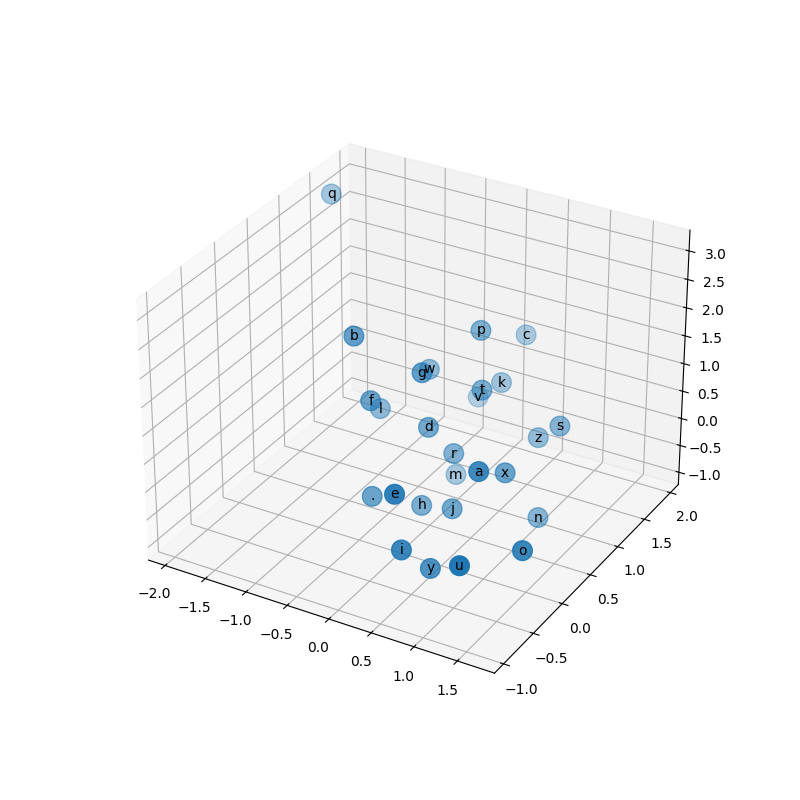

In [ ]:
%matplotlib widget

C = best_config["C"]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(C[:,0].data, C[:,1].data, C[:,2].data, s=200)
for i in range(C.shape[0]):
    ax.text(C[i,0].item(), C[i,1].item(), C[i,2].item(), itos[i],
            ha='center', va='center', color='black')
plt.show()

0


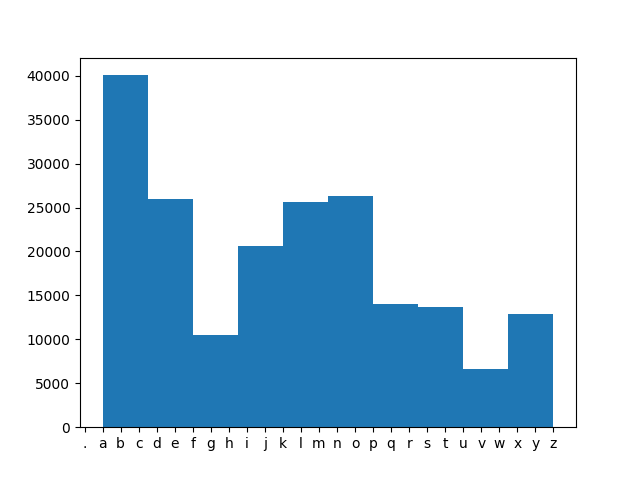

In [ ]:
import numpy as np
raw_chars = np.array([stoi[s] for s in ''.join(words)])
print(sum(raw_chars == "q"))

def dist(x, y):
    return torch.norm(x - y, p=2)


plt.figure()
plt.hist(raw_chars)
plt.xticks(np.arange(len(itos)), [itos[i] for i in range(len(itos))])
plt.show()

In [27]:
nbr_neurons = 512
vocab_size = 27
emb_dim = 3
block_size = 5 # context window size

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size, emb_dim), generator=g)
W1 = torch.randn((emb_dim*block_size, nbr_neurons), generator=g)
b1 = torch.randn(nbr_neurons, generator=g)
W2 = torch.randn((nbr_neurons, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) 

22124

In [28]:
for p in parameters:
        p.requires_grad = True 
stepi, lossi, Ci = [], [], []


In [39]:
n = 1000000
batch_size = 50

# rebuild the datasets using the current block_size (which is 5)
Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)


for i in range(n):
    # minibatch construct 
    ixs = torch.randint(0, Xtr.shape[0], (batch_size,)) 

    # Forward pass 
    emb = C[Xtr[ixs]] 
    h = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ytr[ixs]) 

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    if i < 0.75 * n:
        l = 0.1
    elif i < 0.90 * n:
        l = 0.01
    else: 
        l = 0.001
  

    
    for p in parameters:
        p.data += -l * p.grad 

    stepi.append(i)
    lossi.append(loss.item())
    C_clone = C.detach().clone()
    Ci.append(C_clone)

print(loss)

ltr = model_test(Xtr, Ytr)
ldev = model_test(Xdev, Ydev)
ltest = model_test(Xte, Yte)
print("train : ", ltr)
print("dev : ", ldev)
print("test : ", ltest)

tensor(1.9690, grad_fn=<NllLossBackward0>)
train :  tensor(1.8511, grad_fn=<NllLossBackward0>)
dev :  tensor(2.0663, grad_fn=<NllLossBackward0>)
test :  tensor(2.0662, grad_fn=<NllLossBackward0>)


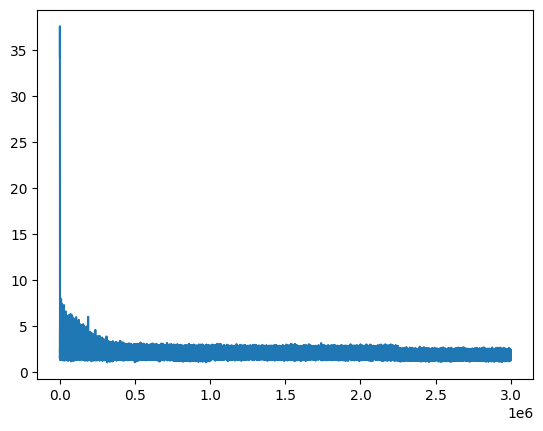

In [40]:
plt.plot(stepi, lossi)


In [41]:
lossi_tens = torch.tensor(lossi)
print(lossi_tens.min())

#plt.plot(stepi[:argmin:], )

tensor(1.0880)


In [156]:
nbr_added_layers = 2
nbr_neurons_hidden = [256 for i in range(nbr_added_layers)]
nbr_neurons_first = 256
vocab_size = 27
emb_dim = 20
block_size = 8

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size, emb_dim), generator=g)
W1 = torch.randn((emb_dim*block_size, nbr_neurons_first), generator=g) / nbr_neurons_first**0.5 # kaiming init
b1 = torch.randn(nbr_neurons_first, generator=g) * 0.1

Ws = []
bs = []
parameters = [C, W1, b1]
for i in range(0, nbr_added_layers):
    W = torch.randn((nbr_neurons_hidden[i], nbr_neurons_hidden[i]), generator=g) / nbr_neurons_hidden[i]**0.5
    b = torch.randn(nbr_neurons_hidden[i], generator=g) * 0.1
    parameters.append(W)
    parameters.append(b)
    Ws.append(W)
    bs.append(b)

Wlast = torch.randn((nbr_neurons_hidden[-1], vocab_size), generator=g) / nbr_neurons_hidden[-1]**0.5
blast = torch.randn((vocab_size), generator=g) * 0.1

parameters.append(Wlast)
parameters.append(blast)

for p in parameters:
    print(p.shape)

print(sum(p.nelement() for p in parameters))


torch.Size([27, 20])
torch.Size([160, 256])
torch.Size([256])
torch.Size([256, 256])
torch.Size([256])
torch.Size([256, 256])
torch.Size([256])
torch.Size([256, 27])
torch.Size([27])
180279


In [157]:
for p in parameters:
        p.requires_grad = True 
stepi, lossi, Ci = [], [], []

In [172]:
n = 1*10**4
batch_size = 50

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

for i in range(n):
    # minibatch construct 
    ixs = torch.randint(0, Xtr.shape[0], (batch_size,)) 

    # Forward pass 
    emb = C[Xtr[ixs]] 
    x = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1) 

    for W, b in zip(Ws, bs): 
        x = torch.tanh(x @ W + b)

    
    logits = x @ Wlast + blast
    loss = F.cross_entropy(logits,Ytr[ixs]) 

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #if i < 0.8 * n:
    #    l = 0.1
    #else:
    #    l = 0.01
    l=0.01
    
    for p in parameters:
        p.data += -l * p.grad 

    stepi.append(i)
    lossi.append(loss.item())
    C_clone = C.detach().clone()
    Ci.append(C_clone)

In [173]:
def deep_model_test(X,Y):
    emb = C[X] 
    x = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1) 
    for W, b in zip(Ws, bs): 
        x = torch.tanh(x @ W + b)
    logits = x @ Wlast + blast
    loss = F.cross_entropy(logits,Y) 

    return loss

ldev = deep_model_test(Xdev, Ydev)
ltest = deep_model_test(Xte, Yte)
ltrain = deep_model_test(Xtr, Ytr)
print("ltrain : ", ltrain)
print("dev : ", ldev)
print("test : ", ltest)

ltrain :  tensor(1.8135, grad_fn=<NllLossBackward0>)
dev :  tensor(1.9996, grad_fn=<NllLossBackward0>)
test :  tensor(1.9917, grad_fn=<NllLossBackward0>)


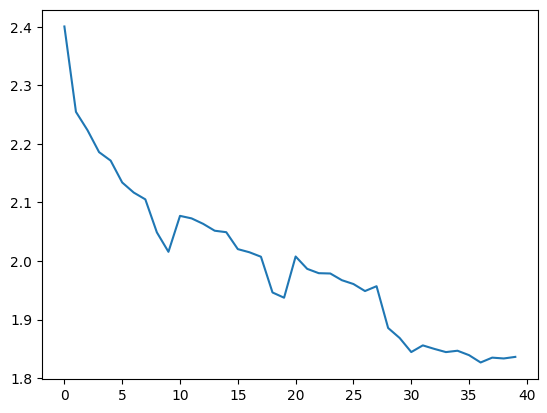

In [170]:
plt.plot(torch.tensor(lossi[:len(lossi)//1000*1000]).view(-1, 1000).mean(1))
#plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))


In [171]:
for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        # Forward
        emb = C[torch.tensor(context)] 
        x = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1) 
        for W, b in zip(Ws, bs): 
            x = torch.tanh(x @ W + b) 
        logits = x @ Wlast + blast
        probs = F.softmax(logits, dim=1)

        # sample from the distrib
        ix = torch.multinomial(probs, num_samples=1).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        if ix ==0:
            break 
    
    print(''.join(itos[i] for i in out))





caile.
ridwlyn.
reya.
raham.
banjory.
juvion.
uria.
anayah.
chaeze.
treek.
kyellie.
katric.
pashson.
nnausha.
brendli.
asiah.
shanth.
isoak.
ruman.
denaya.
